In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import psutil

import pathlib
import os 
import datetime
import sys

from cnn_image_segmentation import resnet_segmentation_model
tf.__version__

'2.0.0'

## Set Up Dataset

In [2]:
def readImage(path):
    return tf.image.decode_png(tf.io.read_file(path))

def readTwoImages(p1, p2):
    return readImage(p1), readImage(p2)

def randScale(imgA, imgB):
    imgAShape = tf.shape(imgA)
    scale = tf.random.normal(mean=1.0, stddev=0.2, shape=())
    scale = tf.clip_by_value(scale, 0.667,1.5)
    
    imgAResized = tf.image.resize(imgA, size=tf.cast( tf.cast(imgAShape, tf.float32)[:2] * scale, tf.int32))
    imgBResized = tf.image.resize(imgB, size=tf.cast( tf.cast(imgAShape, tf.float32)[:2] * scale, tf.int32))
    return imgAResized,imgBResized


def randCrop(a,b, size=512):
    seed = np.random.randint(0,2**16)
    return tf.image.random_crop(a, (size,size,3), seed=seed), tf.image.random_crop(b, (size,size,1), seed=seed)
    

def randFlip(imgA, imgB): 
    seed = np.random.randint(0,2**16)
    return tf.image.random_flip_left_right(imgA, seed=seed), tf.image.random_flip_left_right(imgB, seed=seed)

def randColors(imgA, imgB):
    imgA = imgA - np.array([[[-103.939, -116.779, -123.68 ]]], dtype=np.float32)
    res = tf.image.random_contrast(imgA, 0.8,1.2)
    res = tf.image.random_saturation(res, 0.5,1.6)
    res = tf.image.random_hue(res, 0.3)
    res = tf.clip_by_value(tf.image.random_brightness(res, 32),0,255) + np.array([[[-103.939, -116.779, -123.68 ]]], dtype=np.float32)
    return res, imgB
    
if True:    
    path = pathlib.Path('./data/dice_segmentation/a/')
    pathsA = list(p for p in path.glob('*.png'))
    pathsB = []
    for pathA in pathsA:
        parts = list(pathA.parts)
        parts[-2] = 'b'
        pathsB.append('/'.join(parts))

    pathsA = [str(p) for p in pathsA]


    
def getDS(pathsA, pathsB, cropSize=256, batchSize=5, augment=False):

    ds = tf.data.Dataset.from_tensor_slices((pathsA, pathsB))
    ds = ds.map(readTwoImages)
    
    ds = ds.map(lambda a,b: (tf.cast(a,tf.float32), tf.cast(tf.image.rgb_to_grayscale(b) > 0,tf.float32)))

    ds = ds.map(lambda a,b: (a + np.array([[[-103.939, -116.779, -123.68 ]]], dtype=np.float32), b))

    ds = ds.cache()    
    ds = ds.shuffle(buffer_size=len(pathsA))
    
    if augment:
        ds = ds.map(lambda a,b: randCrop(a,b, int(cropSize * 1.5)))
        ds = ds.map(randScale)
        
    ds = ds.map(lambda a,b: randCrop(a,b, cropSize))
    
    if augment:
        ds = ds.map(randFlip)
        ds = ds.map(randColors)
    
    ds = ds.map(lambda a,b: (a,b[:,:,0]))
    
    
    ds = ds.repeat()
    ds = ds.batch(batchSize)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


splitPoint = int(len(pathsA) * 0.8)

dsTrain = getDS(pathsA[:splitPoint], pathsB[:splitPoint],cropSize=256, batchSize=32, augment=True)
dsTest = getDS(pathsA[splitPoint:], pathsB[splitPoint:], cropSize=512, batchSize=1)



In [3]:
dsTraiIter = iter(dsTrain)

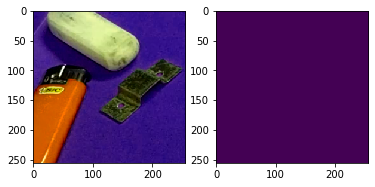

In [4]:
# check dataset
for a,b in dsTraiIter:
    plt.subplot(1,2,1)
    plt.imshow(np.uint8(a[0] - np.array([[[-103.939, -116.779, -123.68 ]]], dtype=np.float32)))
    plt.subplot(1,2,2)
    plt.imshow(np.uint8(b[0], dtype=np.float32))
    plt.show()
    break

## Set Up Model

In [5]:
tf.keras.backend.clear_session()
resnet50, layers = resnet_segmentation_model.getBuildInResNet50(trainable=True, pretrained=True)    
segmentationModel = resnet_segmentation_model.getSegmentationModel(resnet50, layers)

In [6]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = './logs/' + current_time + '/train'
test_log_dir = './logs/' + current_time + '/test'
model_dir = pathlib.Path('./logs/' + current_time + '/model')
model_dir.mkdir(exist_ok=True, parents=True)

train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

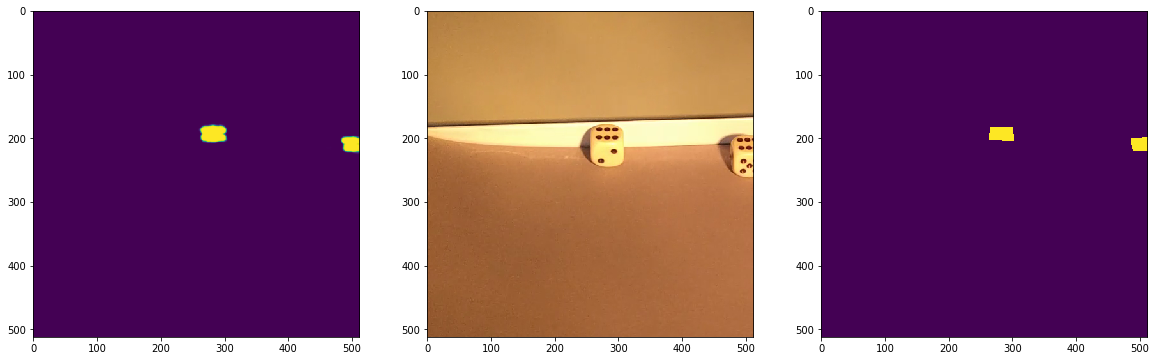

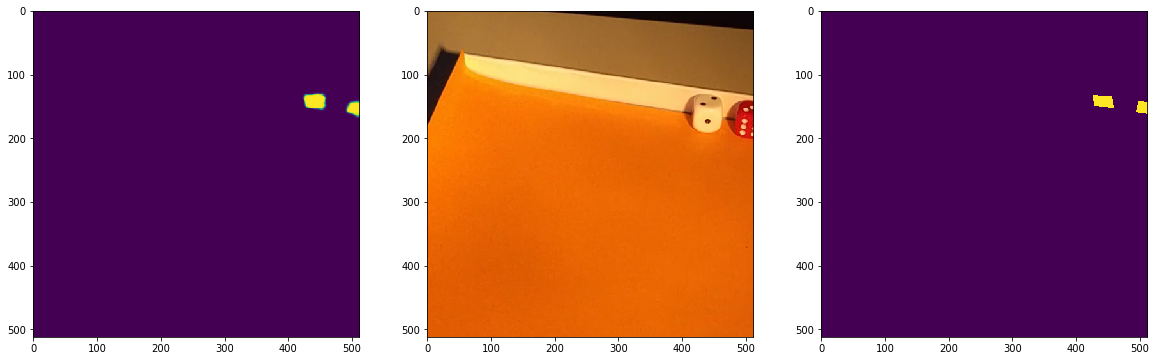

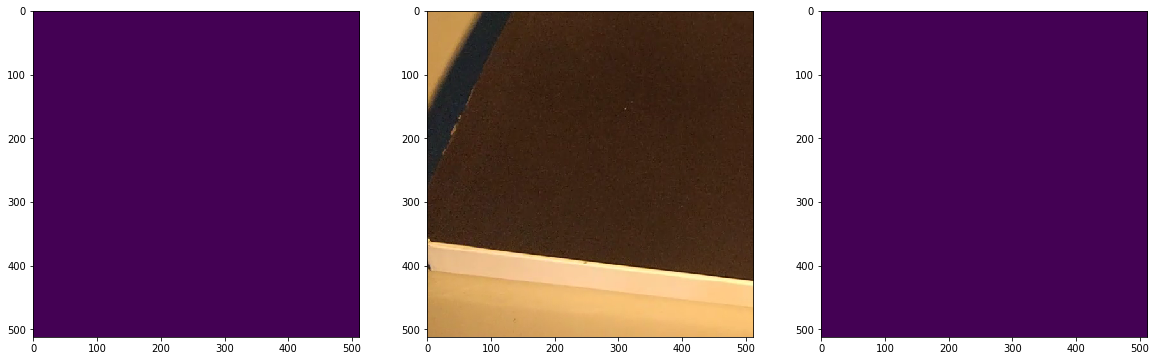

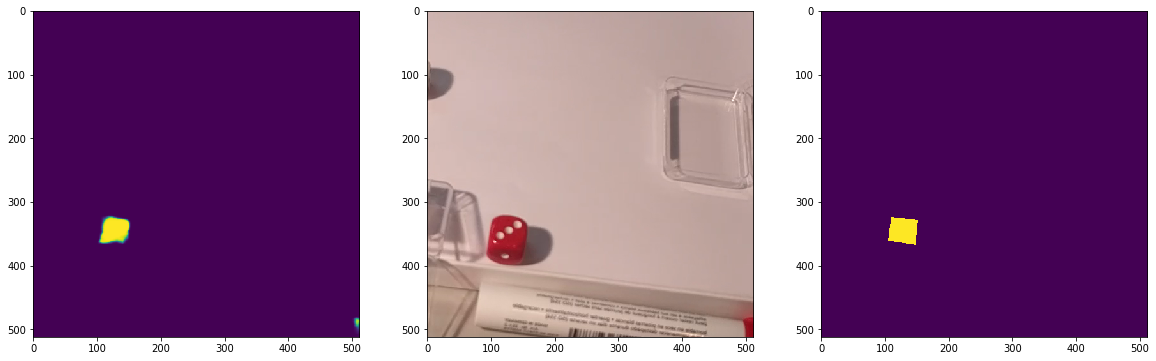

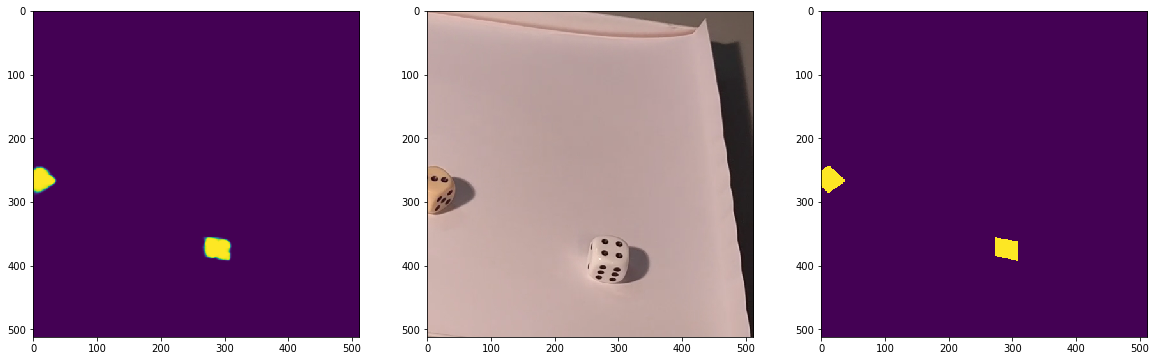

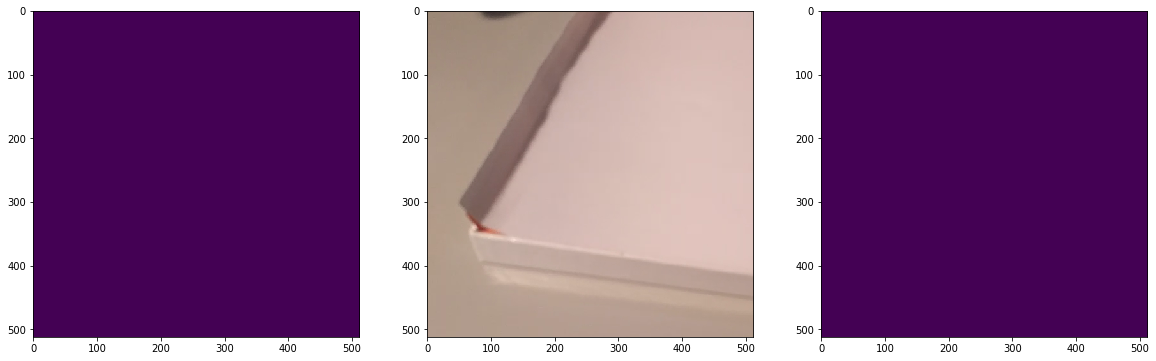

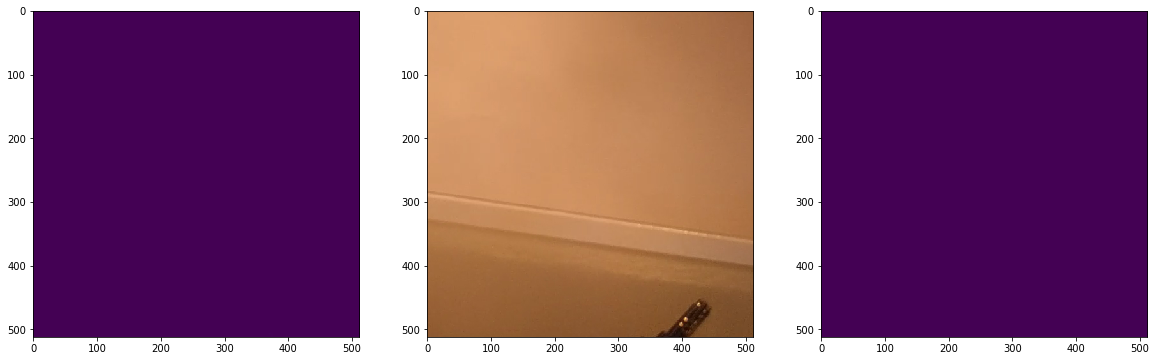

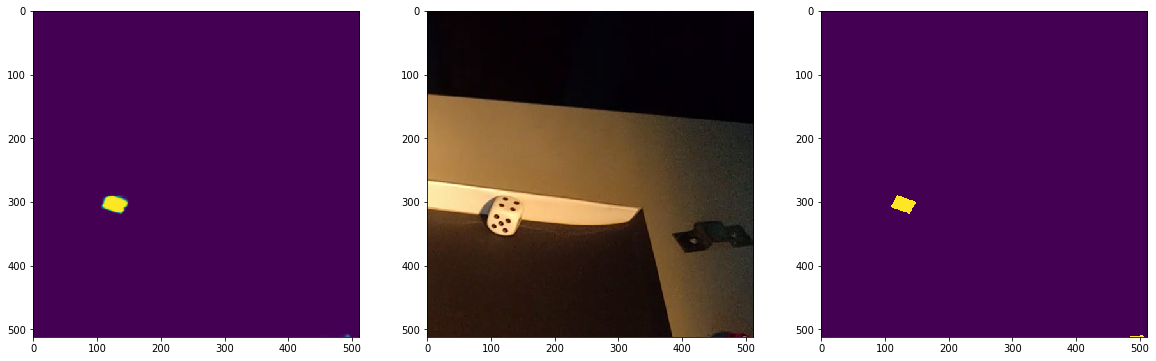

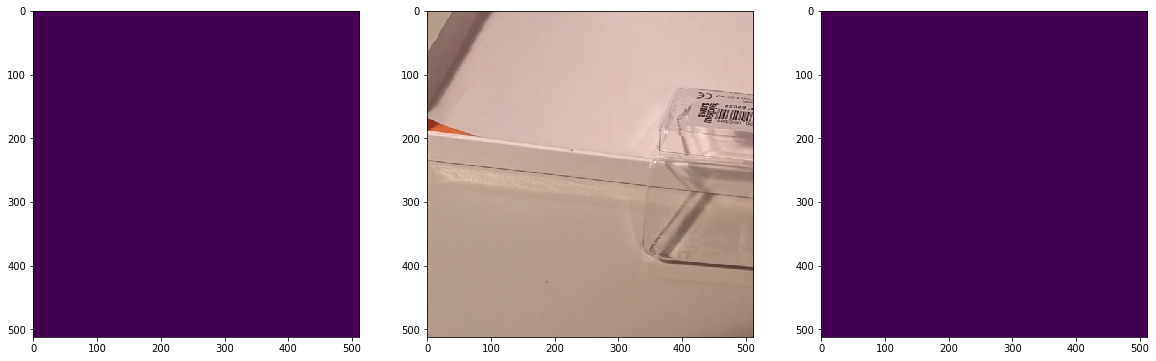

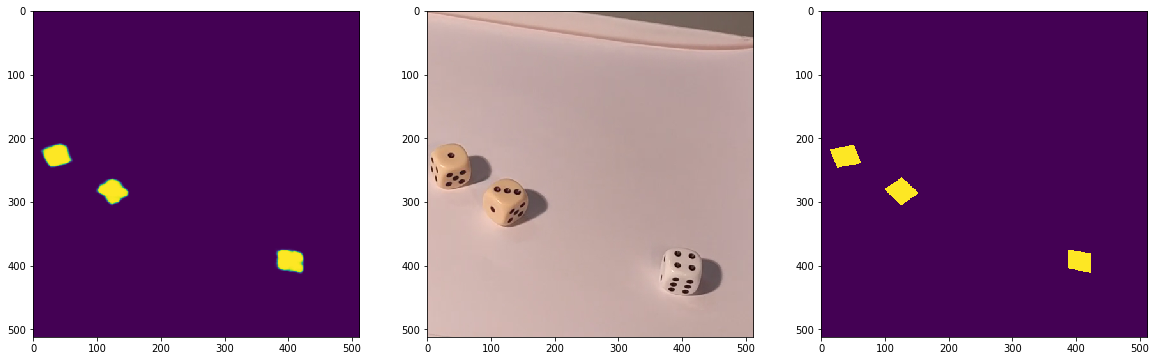

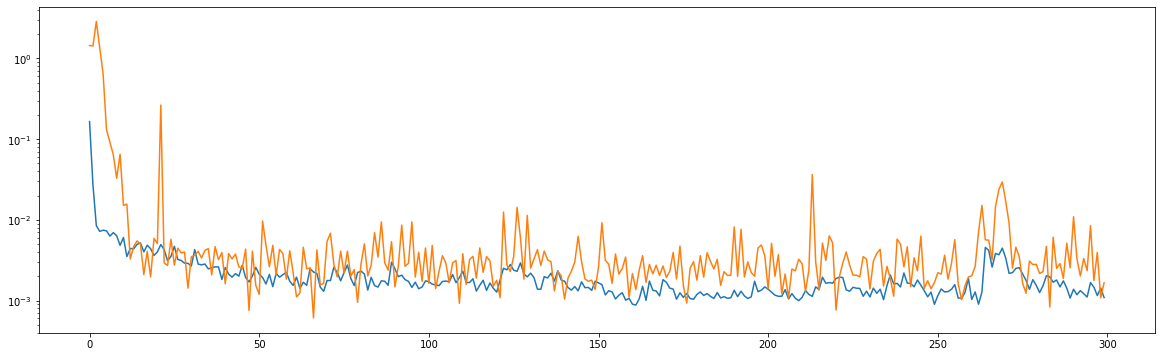

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: logs/20191206-174723/model/assets


In [7]:
from IPython import display
import IPython

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

def getPaddingMask(img):
    img = tf.expand_dims(img,-1)
    pool = tf.keras.layers.AveragePooling2D(pool_size=(3,3), strides=(1,1), padding='SAME')(img)
    return (1.0 - (tf.cast((pool>0) , tf.float32) - img))

@tf.function()
def trainStep(xBatch, yBatch):
    with tf.GradientTape() as tape:
        tape.watch(segmentationModel.trainable_variables)
        res = segmentationModel(xBatch, training=True)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(tf.expand_dims(yBatch,-1), tf.expand_dims(res['logits'],-1)) * getPaddingMask(yBatch)
        
    gradients = tape.gradient(loss, segmentationModel.trainable_variables)
    optimizer.apply_gradients(zip(gradients, segmentationModel.trainable_variables))
    
    trainLoss(tf.reduce_mean(loss))
    trainAccuracy(yBatch, res['sigmoid'])

if True:
    optimizer = tf.optimizers.Adam(0.0010)

    trainLosses = []
    testLosses = []

    dsTrainIter = iter(dsTrain)
    dsTestIter = iter(dsTest)
  
    trainLoss = tf.metrics.Mean()
    trainAccuracy = tf.metrics.BinaryAccuracy()
    
for epoche in range(300):
        

    trainLoss.reset_states()
    trainAccuracy.reset_states()
    for step in range(10):
        xBatch,yBatch = next(dsTrainIter)
        trainStep(xBatch, yBatch)

        
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', trainLoss.result(), epoche)
        tf.summary.scalar('accuracy', trainAccuracy.result(), epoche)
        
    trainLosses.append(trainLoss.result())
    
    testLoss = tf.metrics.Mean()
    testAccuracy = tf.metrics.BinaryAccuracy()
    
    IPython.display.display(plt.gcf())
    IPython.display.clear_output(wait=True)
    
    for step in range(10):
        xTest, yTest = next(dsTestIter)
        res = segmentationModel(xTest,  training=False)
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=yTest, logits=res['logits']))
        testLoss(loss)
        testAccuracy(yTest, res['sigmoid'])

        plt.subplot(1,3,1)
        plt.imshow(res['sigmoid'][0], vmin=0, vmax=1.0)
        plt.subplot(1,3,2)
        plt.imshow(np.uint8(xTest[0] -  np.array([[[-103.939, -116.779, -123.68 ]]], dtype=np.float32)))

        plt.subplot(1,3,3)
        plt.imshow(yTest[0], vmin=0, vmax=1.0)

        plt.show()

    with test_summary_writer.as_default():
        tf.summary.scalar('loss', testLoss.result(), epoche)
        tf.summary.scalar('accuracy', testAccuracy.result(), epoche)
        
    testLosses.append(testLoss.result())
    
    plt.semilogy(trainLosses)
    plt.semilogy(testLosses)
    
  
    
    plt.show()
    
tf.saved_model.save(resnet_segmentation_model.SegmentationModel(segmentationModel) , str(model_dir))
    

## Load Saved Model 

In [8]:
model = tf.saved_model.load(str(model_dir))

## Run loaded model

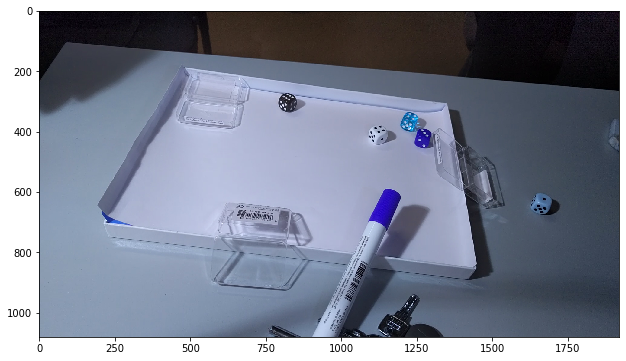

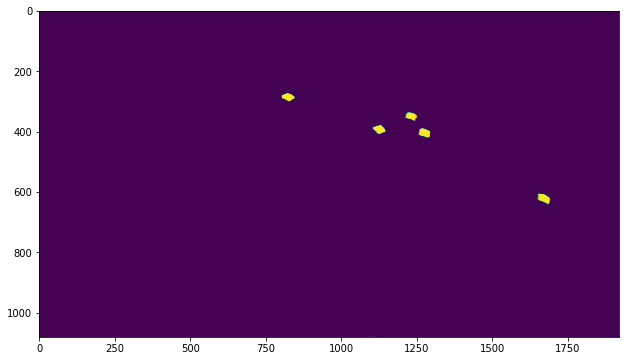

In [9]:
img = cv2.imread(pathsA[-2], cv2.IMREAD_UNCHANGED)
predictions = model(np.float32(img))
plt.imshow(img)
plt.show()
plt.imshow(predictions)
plt.show()